In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:
# %%file node_setup/cre_setup_3_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 11, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [3]:
%%file node_setup/cre_setup_1_scale_1_node_info.csv
node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
10, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
11, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 9,
12, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 10,
13, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 11,
14, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 12,
15, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 13,
16, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




Overwriting node_setup/cre_setup_1_scale_1_node_info.csv


In [4]:
# %%file node_setup/cre_setup_3_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 44,
# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 69,
# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,




In [5]:
# %%file node_setup/cre_setup_2_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,

# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 44,

# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 69,

# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [6]:
# %%file node_setup/cre_setup_1_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,

# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,

# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 44,

# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 69,

# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [7]:
# %%file node_setup/cre_setup_2_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 11, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [8]:
# %%file node_setup/cre_setup_3_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 20, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [9]:
# %%file node_setup/cre_setup_3_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 0, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 0, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 0, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 0, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 1, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 1, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 1, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 1, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 0, 1, 'FKA.pem', -1, 16,
# 17, 'ap-south-1', 0, 1, 'FKA.pem', -1, 17,
# 18, 'ap-south-1', 0, 1, 'FKA.pem', -1, 18,
# 19, 'ap-south-1', 0, 1, 'FKA.pem', -1, 19,
# 20, 'ap-south-1', 0, 1, 'FKA.pem', -1, 20,
# 21, 'ap-south-1', 0, 1, 'FKA.pem', -1, 21,
# 22, 'ap-south-1', 0, 1, 'FKA.pem', -1, 22,
# 23, 'ap-south-1', 0, 1, 'FKA.pem', -1, 23,
# 24, 'ap-south-1', 0, 1, 'FKA.pem', -1, 24,
# 25, 'ap-south-1', 0, 1, 'FKA.pem', -1, 25,
# 26, 'ap-south-1', 0, 1, 'FKA.pem', -1, 26,
# 27, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 28, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
# 29, 'eu-central-1', 0, 2, 'FKE.pem', -1, 27,
# 30, 'eu-central-1', 0, 2, 'FKE.pem', -1, 28,
# 31, 'eu-central-1', 0, 2, 'FKE.pem', -1, 29,
# 32, 'eu-central-1', 0, 2, 'FKE.pem', -1, 30,
# 33, 'eu-central-1', 0, 2, 'FKE.pem', -1, 31,
# 34, 'eu-central-1', 0, 2, 'FKE.pem', -1, 32,
# 35, 'eu-central-1', 0, 2, 'FKE.pem', -1, 33,
# 36, 'eu-central-1', 0, 2, 'FKE.pem', -1, 34,
# 37, 'eu-central-1', 0, 2, 'FKE.pem', -1, 35,
# 38, 'eu-central-1', 0, 2, 'FKE.pem', -1, 36,
# 39, 'eu-central-1', 0, 2, 'FKE.pem', -1, 37,
# 40, 'eu-central-1', 0, 2, 'FKE.pem', -1, 38,
# 41, 'eu-central-1', 0, 2, 'FKE.pem', -1, 39,
# 42, 'eu-central-1', 0, 2, 'FKE.pem', -1, 40,
# 43, 'eu-central-1', 0, 2, 'FKE.pem', -1, 41,
# 44, 'eu-central-1', 1, -1, 'FKE.pem', 2, -1,




In [10]:
# %%file node_setup/cre_setup_3_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [11]:
# %%file node_setup/cre_setup_2_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,

# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 20, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,

# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [12]:
# %%file node_setup/cre_setup_1_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,

# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 20, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,

# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [13]:
# %%file node_setup/cre_setup_1_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,

# 27, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 28, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 28,
# 31, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 29,
# 32, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 30,
# 33, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 31,
# 34, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 32,
# 35, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 33,
# 36, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 34,
# 37, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 35,
# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,

# 44, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [14]:
# %%file node_setup/cre_setup_2_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 28, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 28,
# 31, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 29,
# 32, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 30,
# 33, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 31,
# 34, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 32,
# 35, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 33,
# 36, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 34,
# 37, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 35,
# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [15]:
# %%file node_setup/cre_setup_2_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [16]:
# %%file node_setup/cre_setup_1_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [17]:
# config_list = ['cre_setup_1_scale_1_node_info',\
#                'cre_setup_1_scale_2_node_info',\
#                'cre_setup_1_scale_3_node_info',\
#                'cre_setup_1_scale_5_node_info',\
#                'cre_setup_2_scale_1_node_info',\
#                'cre_setup_2_scale_2_node_info',\
#                'cre_setup_2_scale_3_node_info',\
#                'cre_setup_2_scale_5_node_info',\
#                'cre_setup_3_scale_1_node_info',\
#                'cre_setup_3_scale_2_node_info',\
#                'cre_setup_3_scale_3_node_info',\
#                'cre_setup_3_scale_4_node_info',\
#                'cre_setup_3_scale_5_node_info']



config_list = ['cre_setup_1_scale_1_node_info']

In [18]:
# config_file = config_list[0]

In [19]:
def run_bftsmart_mc(config_file):


    os.system('cp node_setup/'+config_file+'.csv node_info.csv')


    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count

    replica_count = 0

    for key in node_info_dict['cluster_id'].keys():
        if node_info_dict['cluster_id'][key] ==0:
            replica_count = replica_count + 1


    replica_count       

    node_info_dict

    n_clusters = int(total_count / replica_count)

    nclients = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])
        if node_info_dict['ServerOrClientregion'][i] == 1:
            nclients = nclients + 1
    nclients

    clusters_tracked = []
    cluster_regions_tracked = []

    for key in node_info_dict['region']:
        if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
            clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
            cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


    cluster_regions_tracked     

    cluster_regions_tracked, clusters_tracked


    regions = cluster_regions_tracked


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'europe-west3-c', 'europe-west3-c', 'europe-west3-c', 'europe-west3-c', \
    #            'asia-south1-c', 'asia-south1-c', 'asia-south1-c', 'asia-south1-c']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b', \
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = [ 'europe-west3-c', 'asia-south1-c']

    # regions = [ 'us-west1-b', 'us-west1-b']



    # regions = [ 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b']
    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = ['europe-west3-c',  \
    #            'asia-south1-c']


    n_regions = len(regions)

    for i,k in enumerate(regions):
        print(i,k)

    for item, idx in enumerate(node_info_dict['region'].keys()):
        print(item, idx, node_info_dict['region'][item])

    lines  = []
    # zones = {}


    # lim = 0
    # for reg in regions:
    #     for i in range(replica_count+int(nclients/n_clusters)):
    #         line = 'gcloud compute instances create resdb-'+f"{lim+i:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

    #         print(line)
    #         lines.append(line)
    #         zones[i] = reg

    #     lim = lim + replica_count+int(nclients/n_clusters)




    # with open('launch_cloud_instances.sh', 'w') as f:
    #     for item in lines:
    #         f.write(str(item) + '\n')


    for idx, key in enumerate( node_info_dict['region'].keys()):

        line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
        lines.append(line)

    with open('launch_cloud_instances.sh', 'w') as f:
        for item in lines:
            f.write(str(item) + '\n')


    len(lines), node_info_dict['region'][key].strip()[1:-1]


    def run_command(command):
        subprocess.call(command, shell=True)

    commands = lines

    # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
        # Submit each command to the executor for parallel execution
        futures = [executor.submit(run_command, command) for command in commands]

        # Wait for all tasks to complete
        concurrent.futures.wait(futures)

    time.sleep(30)

    # os.system('sh launch_cloud_instances.sh')

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
            shutil.rmtree(folder)

    # os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

    # os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

    instance_type = 'e2-small'


    redirect = '>'

    os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_internal_ips')



    os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
          redirect+' all_external_ips')

    with open('all_internal_ips') as f:
        ipList = f.read().splitlines()
    ipList = [x for x in ipList if x!='None']

    ipList, len(ipList)

    new_server_only_ips= []
    new_client_only_ips= []



    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            new_server_only_ips = new_server_only_ips + [ipList[i]]
        else:
            new_client_only_ips = new_client_only_ips + [ipList[i]]



    # new_server_only_ips= []
    # new_client_only_ips= []


    # current_region_total = 0
    # for i in range(n_regions):
    #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
    #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

    #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
    #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


    #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

    new_server_only_ips, len(new_server_only_ips)

    new_client_only_ips, len(new_client_only_ips) 

    # ipList = new_server_only_ips + new_client_only_ips

    # ipList, len(ipList)

    nclients = 0
    nservers = 0
    count = 0

    clusterIpMap = {}


    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 0:
            clusterIpMap[nservers] = ipList[count]
            nservers = nservers + 1

        count = count + 1

    nclients = 0
    nservers = 0
    count = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 1:
            print('test: ', 7001+nclients, ipList[count])
            clusterIpMap[7001+nclients] = ipList[count]
            nclients = nclients + 1

        count = count + 1

    clusterIpMap

    # clusterIpMap = {}

    # for i in range(len(ipList)):
    #     clusterIpMap[i] = ipList[i]


    # for i in range(nclients):

    #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

    clusterPortMap1 = {}
    clusterPortMap2 = {}

    for i in range(len(ipList) - nclients):

        clusterPortMap1[i] = str(10000)

    for i in range(len(ipList) - nclients):
        clusterPortMap2[i] = str(20000)

    # clusterPortMap1[7003] = '11400'
    # clusterPortMap2[7003] = '11410'



    temp = 11900

    for i in range(nclients):

        clusterPortMap1[7001+i] = str(10000)
        clusterPortMap2[7001+i] = str(20000)

    clusterPortMap1, clusterPortMap2

    os.system('echo 3108 | sudo -S ./gradlew installDist')

    for i in range(total_count):
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

    os.system('echo 3108 | sudo -S ./gradlew clean')

    for key in clusterPortMap1.keys():
        if key>7002:
    #         print(key)
            print()

            for folder in os.listdir('config/'):
                if os.path.isdir('config/'+folder) and 'keys' in folder:
                    if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                        shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                        shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

            print('----------')
            print()

    for i in range(n_clusters):

        if os.path.exists('config'+str(i)):
            shutil.rmtree('config'+str(i))

        os.mkdir('config'+str(i))
        os.mkdir('config'+str(i)+'/keysRSA')
        os.mkdir('config'+str(i)+'/keysSunEC')
        os.mkdir('config'+str(i)+'/keysECDSA')

    #     print('config'+str(i)+'/keysECDSA')


        shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
        shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
    #     print('config/workloads/', 'config'+str(i)+'/workloads')


        for file in os.listdir('config/keys/'):

            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


        shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
        shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





    clusterIpMap, clusterPortMap1

    def find_key_by_value(dictionary, value):
        for key, val in dictionary.items():
            if val == value:
                return key
        # If the value is not found, you might want to handle this case accordingly.
        return None


    node_info_dict

    find_key_by_value(node_info_dict['ServerID'], 4)

    for n_cluster in range(n_clusters):

        with open('config'+str(n_cluster)+'/hosts.config','w') as file:

            for key in clusterIpMap:
                if key < 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                    print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
            for key in clusterIpMap:
                if key >= 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                    print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

            file.close()


    # for n_cluster in range(n_clusters):

    #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

    #         for n_cluster1 in range(n_clusters):

    #             for i_replica in range(replica_count):
    #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
    #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

    #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
    #             print((n_clusters*replica_count) + iter_)

    # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
    #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

    #         for i in range(nclients):
    #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


    #         file.close()


    replica_count

    # for n_cluster in range(n_clusters):
    #     with open('config'+str(n_cluster)+'/system.config','r') as file:
    #         data = file.readlines()
    #         f = int(np.ceil((replica_count-1)/3))
    #         print('f is',f )

    #         for n_line in range(len(data)):
    #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


    #                 data[n_line] = 'system.servers.num = '+str(replica_count)
    #                 print(data[n_line])

    #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.servers.f = '+str(f)
    #                 print(data[n_line])


    #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.initial.view = '
    #                 for iter_view in range(replica_count):
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    #                     print(data[n_line])

    #                 data[n_line] = data[n_line][:-1]
    #                 print(data[n_line])



    #         file.close()

    #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
    #         for line in data:
    #             f.write(f"{line}\n")




    for n_cluster in range(n_clusters):
        with open('config'+str(n_cluster)+'/system.config','r') as file:
            data = file.readlines()


            nservers = 0
            server_id_list = []



            for i in node_info_dict['ServerOrClientregion']:
                if node_info_dict['ServerOrClientregion'][i] == 0 and \
                node_info_dict['cluster_id'][i]  == n_cluster:
                    nservers = nservers + 1
                    server_id_list.append(node_info_dict['ServerID'][i])

            f = int(np.ceil((nservers-1)/3))
            print('f is',f )


            for n_line in range(len(data)):
                if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                    data[n_line] = 'system.servers.num = '+str(nservers)
                    print(data[n_line])

                if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.servers.f = '+str(f)
                    print(data[n_line])


                if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.initial.view = '
                    for iter_view in server_id_list:
                        data[n_line] = data[n_line] +str(iter_view)+','
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                        print(data[n_line])

                    data[n_line] = data[n_line][:-1]
                    print(data[n_line])



            file.close()

        with open('config'+str(n_cluster)+'/system.config', 'w') as f:
            for line in data:
                f.write(f"{line}\n")


    for n_cluster in range(n_clusters):
        for i in range(400):

            for ncls in  range(1):


    #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

    # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

    time.sleep(30)

    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
    # regions = [ 'us-west1-b']


    instance_type = 'e2-small'

    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    f = open('all_external_ips', "r")
    data1 = [line.strip() for line in f.readlines()]

    data1 = [x for x in data1 if x!='None']

    f = open('all_internal_ips', "r")
    data2 = [line.strip() for line in f.readlines()]

    data2 = [x for x in data2 if x!='None']

    data2, len(data2)

    data = []

    skip_instances = 0

    for i in range(skip_instances, len(data1)):
        if data1[i]!='None':
            data.append(data1[i] + '    ' + data2[i])

    data, len(data)

    for index, item in enumerate(data1):
        if 'publicIP' not in node_info_dict.keys():
            node_info_dict['publicIP'] = {}


        node_info_dict['publicIP'][index] = item 


    for index, item in enumerate(data2):
        if 'privateIP' not in node_info_dict.keys():
            node_info_dict['privateIP'] = {}

        node_info_dict['privateIP'][index] = item 



    for index, item in enumerate(data):
        if 'publicAndprivateIP' not in node_info_dict.keys():
            node_info_dict['publicAndprivateIP'] = {}

        node_info_dict['publicAndprivateIP'][index] = item 

    node_info_dict









    # time.sleep(60)

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count





    def getTimeThps(file, flag):

        f = open(file, "r")
        data = f.readlines() 

        times = []
        thputs = []
        for line in data:
            if 'throughput[ops/s]' in line:
                lineData = (line[13+line.find('max[ops/s])>'):-2])
                print(lineData)

                times.append(lineData.split('|')[0])
                thputs.append(lineData.split('|')[-2])
        if (flag): 
            times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
            thputs.append(0)

        return np.array(times).astype(float), np.array(thputs).astype(float) 

    with open('all_external_ips') as f:
        lines = f.read().splitlines()


    lines = [x for x in lines if x!='None']
    lines, len(lines)

    for ip in lines:
        if ip!='None':
            current = (ip.split('.'))

            print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

    ## Set number of clusters

    nclusters = 0

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config':
            nclusters = nclusters + 1


    print(nclusters)





    nreplicas = int(total_count/nclusters)
    nclients = nclusters


    nodeIps = []
    clientIps = []

    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            nodeIps.append(lines[i])
        else:
            clientIps.append(lines[i])


    # nodeIps = lines[:nclusters* nreplicas]


    # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
    no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



    # clientIps = lines[-(nclusters):]



    # clientIps = lines[-nclients:]



    clientIps, no_cluster_yet_nodes



    node_info_dict

    node_info_dict['region'][0].strip()

    ## Functions

    def setup(i):

        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

            print(command)
            os.system(command)

    def initialize(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


            os.system(command)


    def git_clone(i):
        ip = lines[i]
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


            os.system(command)

    def git_pull(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


            os.system(command)

    def compile_job(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


            os.system(command)



    def clean_job(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm config/currentView; '
        for iter_ in range(nclusters):
            rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


            os.system(command)


    def clean_all(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


            os.system(command)





    #     if ip!='None' and( ip in no_cluster_yet_nodes):

    #         current = (ip.split('.'))
    #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
    #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


    #         os.system(command)        
    # #         print(command)

    def check_node(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


            os.system(command)
    #         print(command)


    def run_basic_client(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            current = (ip.split('.'))


            cmd_arg = str(node_info_dict['clientID'][i])



            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


            os.system(command)


    def kill_java(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


            os.system(command)



    def kill_clients(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and ip in clientIps:
            current = (ip.split('.'))
            command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


            os.system(command)

    def run_server_node_check(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


            print(command)



    # for i in range(len(lines)):
    #     run_server_node_check(i)

    def run_basic_client_check(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            cmd_arg = str(node_info_dict['clientID'][i])


    #         print(i, cmd_arg)

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


            print(command)



    ## First Time Setup

    lines, len(lines)

    # for i in range(10):
    #     setup(i)


    results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
    print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
    print(results)  

    # ## GIT Clone/Pull



    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


    # print(results)  

    # ## Compile Job

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    print(results)  

    # ## CLEAN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    # print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


    def run_server_node(i):
        ip = node_info_dict['publicIP'][i] 
    #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


            os.system(command)



    # for i in node_info_dict['publicIP']:
    #     run_server_node(i)

    ## RUN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  

    ### CHECK NODE RESULT

    # check_node(0)

    # ## Run basic client

    # # time.sleep(20)
    # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
    # print(results)  

    # check_node(0)

    # time.sleep(60)

    # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

    ## Main Job

    # os.system('git add .; git commit -m "test";git push')

    experiment = config_file + 'cre_t_'+str(total_count)+'_clusters_'+str(nclusters)

    # time.sleep(60)

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


    #     %%time


    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    # print(results) 





    results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


    results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  


    print('XXXXXXXX Started Servers XXXXXXXXXXXX')

    time.sleep(40)

    check_node(7)



    print('XXXXXXXX Started Clients XXXXXXXXXXXX')

    results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

    time.sleep(180)

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    check_node(0)

    if not os.path.exists('../Experiments/'+experiment):
        os.mkdir('../Experiments/'+experiment)

    os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

            os.system(command)

#             break;



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 



        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
            print(command)
            os.system(command)


    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        print(i)
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)


    node_info_dict

    clientIps



    def getTimesThputs(file):
        f = open(file, "r")
        data = f.readlines() 
        times = []
        thputs = []
        latencies = []
        for line in data:
    #         print(line)
            if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

    #         print(line)
                times.append(line.split('sec:')[0].strip())
                thputs.append(line.split(';')[1].split('current')[0].strip())
                latencies.append(line.split('=')[1].split(']')[0].strip())

                print(line,latencies[-1],thputs[-1],times[-1])

        return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  



    times_thputsDict = {}
    times_latsDict = {}

    for ip in clientIps[:1]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

        print(times, thputs)
        for i in range(len(times)):
            times_thputsDict[times[i]] = thputs[i]
            times_latsDict[times[i]] = lats[i]


    for ip in clientIps[1:]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


        for i in range(len(times)):

            if times[i] in times_thputsDict.keys():
                times_thputsDict[times[i]] += thputs[i]

            if times[i] in times_latsDict.keys():
                times_latsDict[times[i]] += lats[i]


    times_thputsDict



    PIK = '../Experiments/'+experiment+"/pickle.dat"

    data = [times_thputsDict, times_latsDict]

    with open(PIK, "wb") as f:
        pickle.dump(data, f)

    experiment

    # experiment = 'TestRun2_8_clusters_2'
    # PIK = '../Experiments/'+experiment+"/pickle.dat"

    data2 = []
    with open(PIK, "rb") as f:
        data2 =  pickle.load(f)


    dict1 = data2[0]
    dict2 = data2[1]



    times1 = np.array(list(dict1.keys()))
    thputs = np.array(list(dict1.values()))

    times2 = np.array(list(dict2.keys()))
    lats = np.array(list(dict2.values()))

    times1


    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


    pl.title(r'Throughput')


    pl.xlabel('Time (s)')
    pl.ylabel('Throughput (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
    pl.show()




    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


    pl.title(r'Latency')


    pl.xlabel('Time (s)')
    pl.ylabel('Latency (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
    pl.show()

    times1, lats

    lats, np.average(lats[-85:-5])/len(clientIps)

    np.sum(thputs),  np.average(thputs[-85:-5])

    thputs

    np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

    # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

    np.sum((thputs[:180]))

    np.sum((thputs[:180]))

0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.36  34.107.0.56  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A sugges

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.41  35.198.105.85  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.42  35.198.66.215  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.58  34.141.113.196  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.55  34.159.70.192  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.38  34.159.126.10  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.26  35.200.207.90  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.31  34.93.219.165  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.40  34.107.87.59  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-12  asia-south1-c  e2-highmem-2               10.160.0.32  34.100.245.84  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.39  34.107.45.189  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.56  34.141.61.166  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.37  34.159.90.112  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.11  34.93.236.226  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.8   35.200.204.131  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-11].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.44  35.198.69.222  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-11  asia-south1-c  e2-highmem-2               10.160.0.28  34.93.134.53  RUNNING
test:  7001 10.156.0.56
test:  7002 10.156.0.37
test:  7003 10.160.0.31


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 998ms
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 479ms
1 actionable task: 1 executed

----------

test:  0 10.156.0.44 10000 20000 0

test:  1 10.156.0.39 10000 20000 0

test:  2 10.156.0.42 10000 20000 0

test:  3 10.156.0.36 10000 20000 0

test:  4 10.156.0.38 10000 20000 0

test:  5 10.156.0.55 10000 20000 0

test:  6 10.156.0.58 10000 20000 0

test:  7 10.156.0.40 10000 20000 1

test:  8 10.156.0.41 10000 20000 1

test:  9 10.160.0.28 10000 20000 1

test:  10 10.160.0.32 10000 20000 1

test:  11 10.160.0.8 10000 20000 1

test:  12 10.160.0.11 10000 20000 1

test:  13 10.160.0.26 10000 20000 1

test:  7001 10.156.0.56 10000

test:  7002 10.156.0.37 10000

test:  7003 10.160.0.31 10000

test:  0 10.156.0.44 10000 20000 0

test:  1 10.156.0.39 10000 20000 0

test:  2 10.156.0.42 10000 20000 0

test:  3 10.156.0.36 10000 20000 0

test:  4 10.156.0.38 10000 20000 0

test:  5 10.156.0.55 10000 20000 0

test:  6 10.156.0.58 10000 20000 0

test:  7 10.156.0.40 10000 20000 1

test:  8 10.156.0.41 10000 2

To github.com:tmane002/BftSmart_Final.git
   4558d52d..c356f607  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-44.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-39.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-42.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-36.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-38.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-55.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-58.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-40.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-41.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-56.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-37.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-32.us-west-1.compute.

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:16 http://europe-west3.gce.archive.u

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe a

Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-upd

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [

Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/u

Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:30 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:31 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-back


Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglv

Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 2s (20.6 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected packa

Reading package lists...
Building dependency tree...Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading package lists...

Building dependency tree...
Reading state information...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 29.7 MB in 6s (5111 kB/s)
Reading package lists...

Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...

Reading state information...
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1


Building dependency tree...Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
Reading package lists...
Building dependency tree...Get

Reading package lists...
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
Building dependency tree...Reading package lists...
Reading state information...
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.


Building dependency tree...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.



Reading package lists...
Reading state information...
Reading package lists...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0

Building dependency tree...  libqmi-glib5 libqmi-proxy libudisks2-0 li





Use with caution in scripts.









Reading state information...
Building dependency tree...Reading package lists...Building dependency tree...

Reading state information...Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0

  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon

1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-cli

  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0 libpcsclite1
  libsensors-config libsensors5 libsm6 libvulkan1 libwayland-client0
  libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0
  libxcb-randr0 libxcb-shape0 libxcb-shm0 libxcb-sync1 libxcb-xfixes0
  libxcomposite1 libxfixes3 libxft2 libxi6 libxinerama1 libxkbfile1 libxmu6
  libxpm4 libxrandr2 libxrender1 libxshmfence1 libxt6 libxtst6 libxv1
  libxxf86dga1 libxxf86vm1 mesa-vulkan-drivers openjdk-11-jre
  openjdk-11-jre-headless x11-common x11-utils
Suggested packages:
  cups-common liblcms2-utils pcscd lm-sensors libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
  mesa-utils
Building dependency tree...Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Reading package lists...The following NEW packages will be installed:
  at-spi2-core ca


Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Building dependency tree...The following NEW packages will be installed:
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-6

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

The following packages will be upgraded:
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
  libc6
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following package

The following packages will be upgraded:
  libc6
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
The following packages will be upgraded:
  libc6
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-

Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Reading package lists...Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Setting up linux-libc-dev

Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories currently installed.)Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Setting up g++ (4:9.3.0-1ubuntu2) ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:40 http://europe-west3.gce.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Fetched 48.2 MB in 2s (22.1 MB/s)
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://europe-west3.gce.archive.ubuntu.c

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dia

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Fetched 48.2 MB in 2s (29.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:31 http://eu

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Fetched 48.2 MB in 3s (18.1 MB/s)
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Selecting previously unselected package libctf0:amd64.
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Unpacking l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [67

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Fetched 48.2 MB in 3s (15.7 MB/s)
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
d

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libctf0:amd64.
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Fetched 48.2 MB in 3s (16.1 MB/s)
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
(Reading database ... 90%
debconf: falling back to frontend: Readline
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not w

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unp

Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting p

Selecting previously unselected package cpp-9.
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.1

Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ub

Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1

Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gc

Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...

Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~2

Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package make.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc-9.
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previou

Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Unpacking fakeroot (1.24-1) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package g++-9.
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package g++-9.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package make.
Selecting previously unselected package 

Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...

Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libalgorithm-merge-perl.

Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubunt

Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up g++ (4:9.3.0-1u

Reading package lists...Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking fakeroot (1.24-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...

Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Building dependency tree...Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up fakeroot (1.24-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-perl.
Sel

Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package libfile-fcntllock-perl.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up build-essential (12.8ubuntu1.1) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libisl22:amd64 (0.22.1-

Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...

Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Building dependency tree...Setting up libfakeroot:amd64 (1.24-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up fakeroot (1.24-1) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~2

1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Fetched 396 kB in 0s (5259 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 am

job.sh: 12: sdk: not found



Reading state information...Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://asia-south1.gce.archive.ubuntu.com/ubuntu fo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 3s (14.1 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Fetched 43.0 MB in 1s (41.3 MB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Select

Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-al

0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected pack

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-b

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libq

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 396 kB in 0s (5133 kB/s)
Fetched 396 kB in 0s (4577 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
(Reading database ... 90%
Reading state information...  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4

Fetched 396 kB in 1s (451 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages will be upgraded:
  curl libcurl4se ... 60%
(Reading database ... 67840 files and directories currently installed.)
(Reading database ... 67840 files and directories currently installed.)

Reading state information...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:2 ht

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (4620 kB/s)
Reading package lists...(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Processing tr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Reading package lists...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Building dependency tree...Setting up curl (7.68.0-1ubuntu2.21) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 1s (539 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Fetched 396 kB in 1s (541 kB/s)
The following packages will be upgraded:
  curl libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

(Reading database ... 67840 files and directories currently installed.)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
2 upgraded, 0 newly installed, 0 to remove and 6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Fetched 396 kB in 0s (4178 kB/s)
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 0s (4569 kB/s)
(Reading database ... 95%Reading database ... 65%
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2

job.sh: 12: sdk: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh: 

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre cups-common
  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothi

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]

Reading state information...
Selecting previously unselected package libavahi-common-data:amd64.
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu foc

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Fetched 43.0 MB in 1s (51.5 MB/s)
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 

Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package libavahi-common-data:amd64.

Reading state information...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not 

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



Reading state information...

Reading state information...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jr

job.sh: 12: sdk: not found


Selecting previously unselected package libgraphite2-3:amd64.
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Selecting previously unselected package fonts-dejavu-core.
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libpcsclite1:amd64.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                      

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package java-common.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libavahi-common-data:amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 12: sdk: not found


Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will 

Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfont

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 3s (13.4 MB/s)
Selecting previously unselected package ca-certificates-java.
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 3s (13.3 MB/s)
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...Selecting previously unselected package ca-certificates-java.
(Reading database ... 70%
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certific

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package java-common.
Preparing to

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Fetched 43.0 MB in 3s (14.8 MB/s)
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexe

Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package fontconfig-config.
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libfontconfig1:amd64.
P

Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up ant (1.10.7-1) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
done.
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up ant-optional (1.10.7-1) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Selecting previously unselected package default-

Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pemSetting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...

Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authori

Adding debian:Trustwave_Global_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:CA_Disig_Root_R2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
upd

Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Setting

Adding debian:Secure_Global_CA.pemAdding debian:E-Tugra_Global_Root_CA_ECC_v3.pem

Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pemdone.
done.
Adding debian:SSL.com_Root_Certification_Authority_RSA.pemAdding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem

Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:DigiCert_Assur

head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pemReading package lists...Setting up ant (1.10.7-1) ...
Adding debian:Certum_Trusted_Root_CA.pem

Adding debian:GTS_Root_R3.pemAdding debian:DigiCert_TLS_ECC_P384_Root_G5.pem

Adding debian:Baltimore_CyberTrust_Root.pem
done.
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:certSIGN_Root_CA_G2.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up ant-optional (1.10.7-1) ...
Selecting previously unselected package ant-optional.
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem

Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Preparing to unp

Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:COMODO_ECC_Certification_Auth

Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pemAdding debian:certSIGN_Root_CA_G2.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
done.
done.

Adding debian:certSIGN_ROOT_CA.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:Micr

Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem

Reading state information...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Fetched 396 kB in 1s (505 kB/s)
(Reading database ... 55%Reading database ... 
(Reading database ... 95%..(Reading database ... 70%
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_

Unpacking default-jre-headless (2:1.11-72) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package ant.
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Unpacking ant (1.10.7-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 l

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode

Reading state information...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting 

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
done.
done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternative

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem

Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_R

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding de

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     

job.sh: 12: sdk: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Building dependency tree...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resi

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Fetched 43.0 MB in 3s (14.8 MB/s)
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpac

Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_E

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...10%.................10%.........20%....................10%.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
....30%...............................40%.........20%...................50%.....................60%..........10%...........70%......20%....10%....10%...........80%.30%.........................90%.......................100%
.10%..........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.10%......40%......10%.30%........................50%.....20%.........20%.....20%.................60%............................40%...70%.....................................20%......50%.....80%..........30%....30%..20%.........20%......30%............60%.............90%...10%..........

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: Recompile with -Xlint:unchecked for details.




> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 33s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes
> Task :classes

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 39s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None,

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main c9dd1716] Working with modified ClusterInfo
 1 file changed, 10499 insertions(+), 13389 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   c356f607..c9dd1716  main -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
noh

Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main


Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main


Updating c356f607..c9dd1716
Fast-forward
Updating c356f607..c9dd1716
Fast-forward
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main


Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main


Updating c356f607..c9dd1716
Fast-forward
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c356f607..c9dd1716  main       -> origin/main


Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Updating c356f607..c9dd1716
Fast-forward
 cre_exp_gc.ipynb | 23888 +++++++++++++++++++++++------------------------------
 1 file changed, 10499 insertions(+), 13389 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (s

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView'rm: cannot remove 'config0/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such 

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.40, 10.156.0.40
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:4  ## CipherS

nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

-- ------CHECKING LIMITS----------
-- Received message  type=ACCEPT, number=360, epoch=0, from=6
-- I'm at consensus 360 and my last consensus is 359
-- Message for consensus 360 can be processed
-- Processing paxos msg with id 360
-- Processing consensusMessage from: 6, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 6 for consensus 360
-- I have 3 ACCEPTs for cId:360, Timestamp:0 
-- <-- receiving, msg:type=ACCEPT, number=360, epoch=0, from=1 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 1, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=ACCEPT, number=360, epoch=0, from=1
-- I'm at consensus 360 and my last consensus is 359
-- Message for consensus 360 can be processed
-- Processing paxos msg with id 360
-- Processing consensusMessage from: 1, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT 

-- I'm at consensus 363 and my last consensus is 362
-- Message for consensus 363 can be processed
-- Processing paxos msg with id 363
-- Processing consensusMessage from: 2, type: 44782, propose, write, accept: 44781, 44782, 44783
-- <-- receiving, msg:type=WRITE, number=363, epoch=0, from=6 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 6, type: 44782, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=WRITE, number=363, epoch=0, from=6
-- I'm at consensus 363 and my last consensus is 362
-- Message for consensus 363 can be processed
-- Processing paxos msg with id 363
-- Processing consensusMessage from: 6, type: 44782, propose, write, accept: 44781, 44782, 44783
-- <-- receiving, msg:type=WRITE, number=363, epoch=0, from=5 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 

rm: cannot remove 'cre_setup_1_scale_1_node_infocre_t_14_clusters_2.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_2.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_1.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
[] []
 2 sec: 107 operations; 106.89 current ops/sec; [READ AverageLatency(us)=17800.31] [UPDATE AverageLatency(us)=380073.78] 
 17800.31 106.89 2
 3 sec: 314 operations; 206.59 current ops/sec; [READ AverageLatency(us)=4010.7] [UPDATE AverageLatency(us)=283783.62] 
 4010.7 206.59 3
 4 sec: 421 operations; 106.89 current ops/sec; 

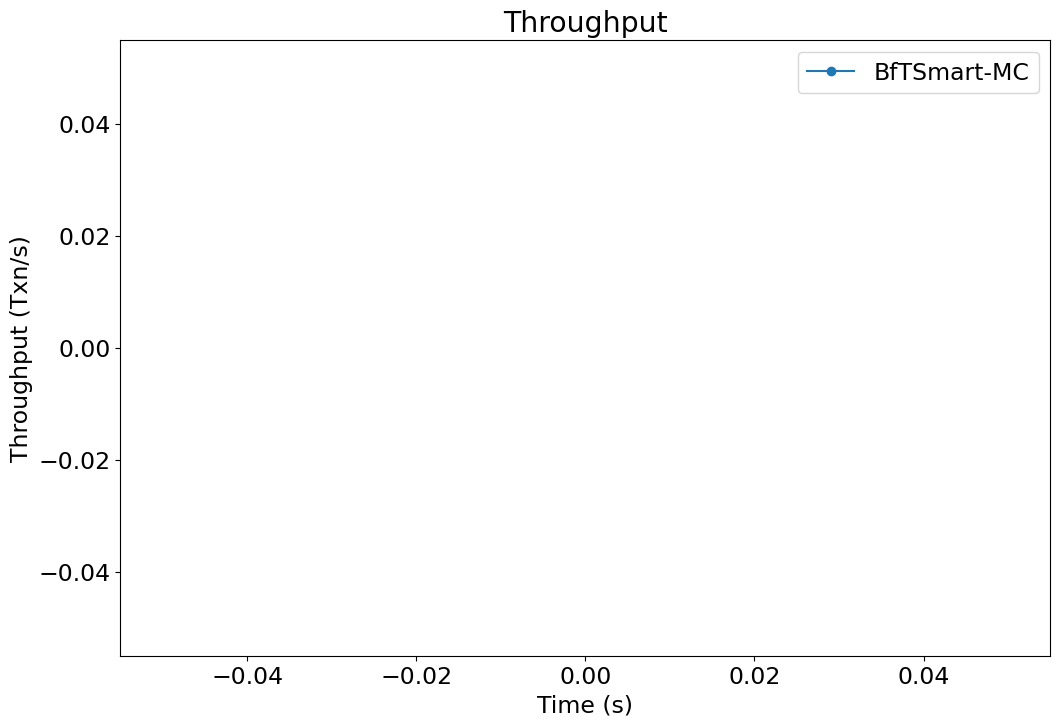

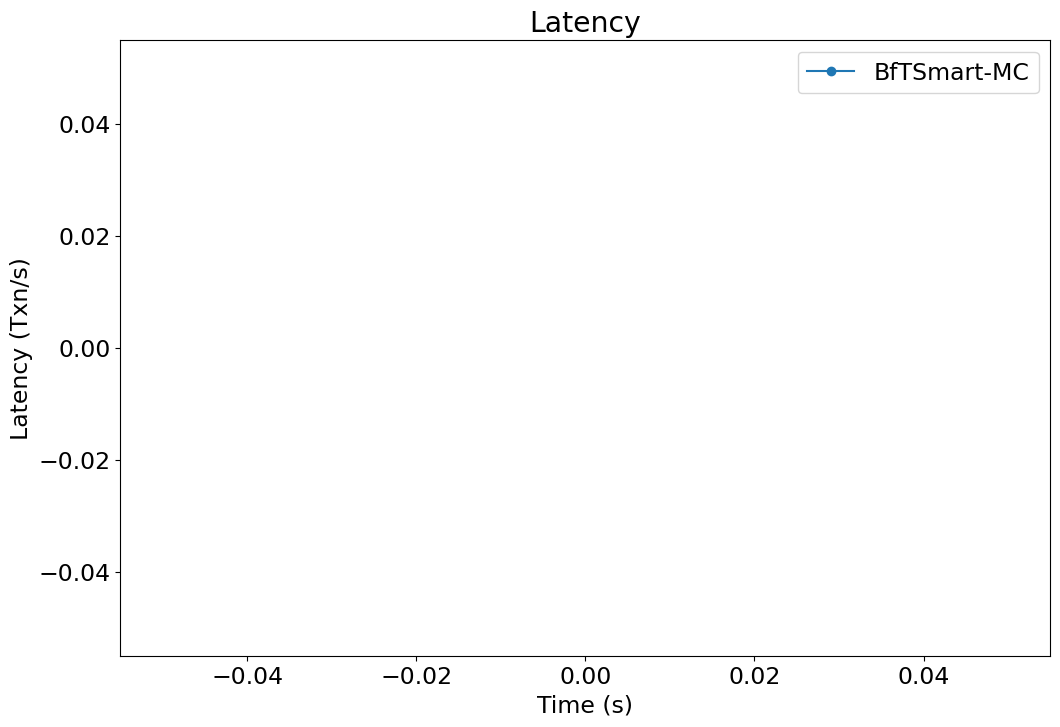

/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/pr

gcloud compute scp --zone "europe-west3-c" commands.sh resdb-08:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-06:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-04:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-01:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-02:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-05:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-12:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-15:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-13:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-07:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-00:/home/tejas/commands.sh
gcloud compute scp --zone "asia-sou

In [20]:
# # %%notify

for cfig in config_list:
    
    
    run_bftsmart_mc(cfig)
    
    
    os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')